In [1]:
%load_ext autoreload
%autoreload 2

## BEST SHORT MODEL 

In [2]:
import sys
sys.path.append('../../')
import tokamakTK
from tokamakTK import MyCounter, HUEOrder

import pydotplus
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')

path = "../../data/"
fig_path = "../../../../LATEX/Latex Images/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# REMOVING SPHERICAL TOKAMAKS
#DB5 = DB5[~DB5.TOK.isin(['MAST', 'NSTX', 'START'])]


# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Decreasing"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Unaffected"

DB5.insert(loc=2,column="label_9998",value=["Decreasing"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Unaffected"

DB5.insert(loc=2,column="label_joe",value=["Decreasing"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Unaffected"



print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


In [4]:
# Low Multicollinearity Features
features  =  ['RHOSTAR', 'NUSTAR', 'Q95', 'BETASTAR']

In [5]:
DB5 = tokamakTK.clean_categorical_data(DB5)

# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()

data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num, SS_scaling=False, UL_scale=False)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1
                 )

In [6]:
X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [7]:
rf = RandomForestClassifier(min_samples_split=2,  
                            min_samples_leaf=1,
                            min_impurity_decrease=0.0005,
                            n_estimators = 211,
                            max_depth = 19,
                            criterion='entropy',
                            max_features=None,
                            n_jobs=-1,
                           )
rf.fit(X_train, y_train)
y_pred=rf.predict_proba(X_test)

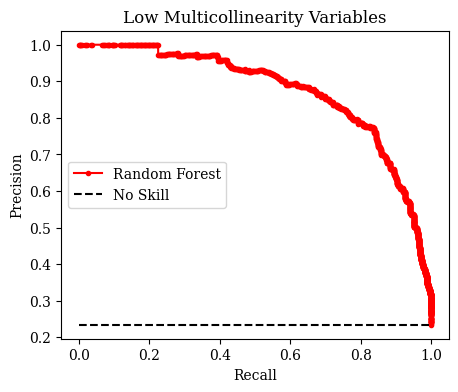

In [8]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive ['NUSTAR', 'TAV', 'RHOSTAR', 'LHTIME'] outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Low Multicollinearity Variables")
plt.legend();

In [9]:
tokamakTK.get_metrics_for_decreasing(rf, X_test, y_test)

(0.78, 0.8, 0.78, 0.79)

[SPARC Safety Factor](https://www.cambridge.org/core/journals/journal-of-plasma-physics/article/overview-of-the-sparc-tokamak/DD3C44ECD26F5EACC554811764EF9FF0)

In [10]:
new_observations = pd.read_csv(path+"new_machines.csv")
new_observations = new_observations.rename(columns={"TAUTH_pred":"TAUTH_pred_joe"})
new_observations = new_observations.set_index("TOK")
new_observations.loc["SPARC", "Q95"] = 3.2

In [11]:
new_observations

,IP,BT,NEL,PLTH,RGEO,KAREA,EPS,MEFF,A,RHOSTAR,BETASTAR,NUSTAR,QCYL5,Q95,TAUTH_exp,TAUTH_pred_joe
TOK,,,,,,,,,,,,,,,,
ITER,15.0,5.3,1.03,87,6.20,1.80,0.322581,2.5,2.00,0.0020,2.24,0.014,1.94,3.0,3.50,2.94
SPARC,8.7,12.2,3.10,25,1.85,1.97,0.308108,2.5,0.57,0.0027,1.20,0.029,2.46,3.2,0.77,0.73


In [12]:
new_observations[features]

,RHOSTAR,NUSTAR,Q95,BETASTAR
TOK,,,,
ITER,0.0020,0.014,3.0,2.24
SPARC,0.0027,0.029,3.2,1.20


In [13]:
y_pred=rf.predict_proba(X_test)

In [14]:
new_observations[features]

,RHOSTAR,NUSTAR,Q95,BETASTAR
TOK,,,,
ITER,0.0020,0.014,3.0,2.24
SPARC,0.0027,0.029,3.2,1.20


In [15]:
rf.predict(new_observations[features])

array([0, 0])

# FEATURE IMPORTANCE

In [16]:
n_permutations = 200
Importance = pd.DataFrame(np.zeros((len(X.columns), 2)), index=X.columns, columns=["mean", "std"])
permutation = permutation_importance(rf, X_test, y_test, n_repeats=n_permutations, 
                                     n_jobs=-1,
                                     scoring="f1_macro",
                                     random_state=71)
for i in permutation.importances_mean.argsort()[::-1]:
    if permutation.importances_mean[i] - 2 * permutation.importances_std[i] > 0:
        Importance.loc[X.columns[i], "mean"] = np.round(permutation.importances_mean[i],4)
        Importance.loc[X.columns[i], "std"] = np.round(permutation.importances_std[i],4)
Importance.sort_values("mean", ascending=False, inplace=True)

In [17]:
Importance


,mean,std
NUSTAR,0.2691,0.0114
RHOSTAR,0.2620,0.0117
Q95,0.1378,0.0094
BETASTAR,0.0832,0.0085


In [19]:
Importance["mean"].sum()

0.7521

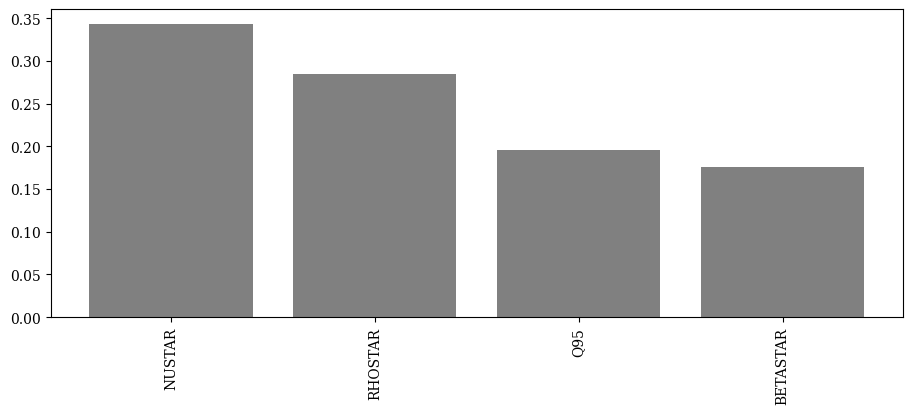

In [20]:
importances = rf.feature_importances_

feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False).reset_index(drop=True)

df = pd.DataFrame(feature_importances)

plt.figure(figsize=(11,4))
plt.bar(df[df.importance > 0.5e-2].feature, df[df.importance > 0.5e-2].importance, color="gray")
plt.xticks(rotation=90);

In [22]:
df.importance.sum()

1.0

In [23]:
df

,feature,importance
0,NUSTAR,0.343615
1,RHOSTAR,0.284782
2,Q95,0.195692
3,BETASTAR,0.175912
